<b>Uwaga:</b> Należy rozwiązać oba poniższe zadania. Na zaliczenie potrzeba co najmniej 3 pkt. 
<p></p>

1. <b>Zadanie 1.</b>(2x1.5 pkt): Zreplikować wyniki  związane z  materiałem na stronie <a href="https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/">2d fourier transform in python and fourier synthesis of images</a>. Istotą tego zadania jest poprawne zrozumienie działania transformaty Fouriera na obrazach  - jego zaliczenie będzie polegało na odpowiedzi na dwa pytania teoretyczne.

2. <b>Zadanie 2.</b>(2x1 pkt): Napisać kod dwóch filtrów opartych o transformatę Fouriera: dolno i górnoprzepustowego. W pierwszym przypadku przykładowy obraz dobrej jakości zaburzyć kolejno trzema różnymi szumami dostępnymi w programie Gimp. W każdym przypadku zastosować filtr dolnoprzepustowy możliwie dokładnie przywracający obraz przed zaszumieniem. Następnie wygenerować filtr górnoprzepustowy wizualizujący w trzech powyższych przypadkach postać dodanego szumu.  Materiał referencyjny znajduje się m.in. na stronie
<a href="https://fairyonice.github.io/Low-and-High-pass-filtering-experiments.html">Low and High pass filtering experiments.html</a>. 

## Zadanie 1

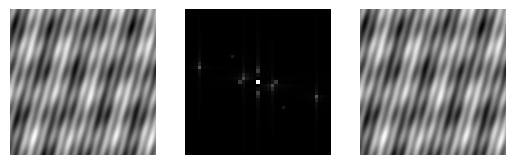

In [19]:
# gratings.py

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-500, 501, 1)

X, Y = np.meshgrid(x, x)

amplitudes = 0.5, 0.25, 1, 0.75, 1
wavelengths = 200, 100, 250, 300, 60
angles = 0, np.pi / 4, np.pi / 9, np.pi / 2, np.pi / 12

gratings = np.zeros(X.shape)
for amp, w_len, angle in zip(amplitudes, wavelengths, angles):
    gratings += amp * np.sin(
        2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / w_len
    )

# Add a constant term to represent the background of image
gratings += 1.25

plt.set_cmap("gray")

plt.subplot(131)
plt.imshow(gratings)
plt.axis("off")

# Calculate Fourier transform of the sum of the gratings
ft = np.fft.ifftshift(gratings)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

plt.subplot(132)
plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])
plt.axis("off")

# Inverse
ift = np.fft.ifftshift(ft)
ift = np.fft.ifft2(ift)
ift = np.fft.fftshift(ift)
ift = ift.real 

plt.subplot(133)
plt.imshow(ift)
plt.axis("off")

plt.show()

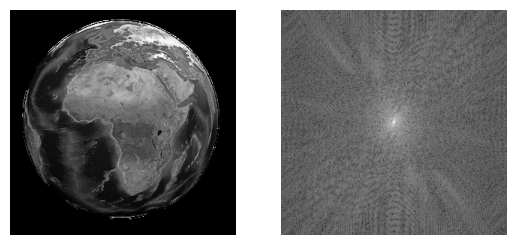

  0%|          | 0/45451 [00:00<?, ?it/s]

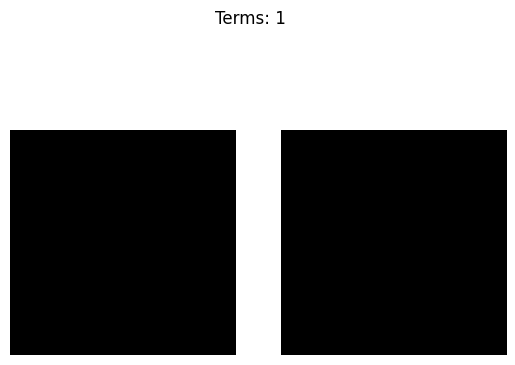

  0%|          | 1/45451 [00:00<1:58:38,  6.38it/s]

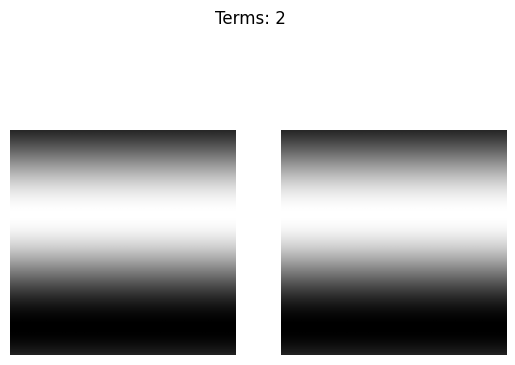

  0%|          | 2/45451 [00:00<2:16:44,  5.54it/s]

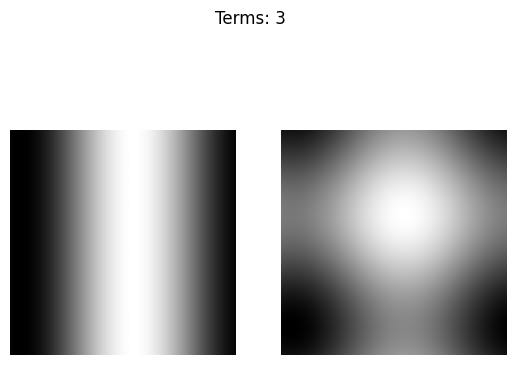

  0%|          | 3/45451 [00:00<2:17:31,  5.51it/s]

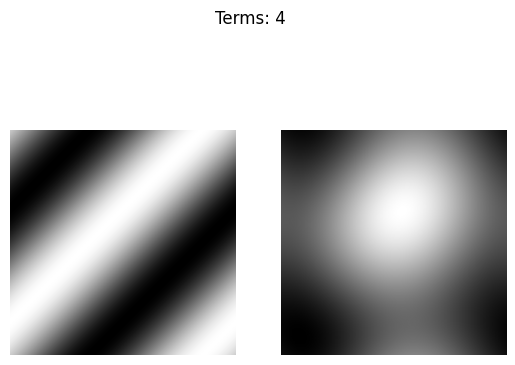

 22%|██▏       | 10071/45451 [00:53<02:21, 249.70it/s]

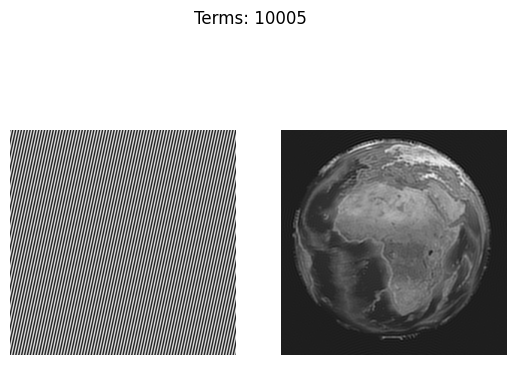

 44%|████▍     | 20103/45451 [01:42<01:51, 227.51it/s]

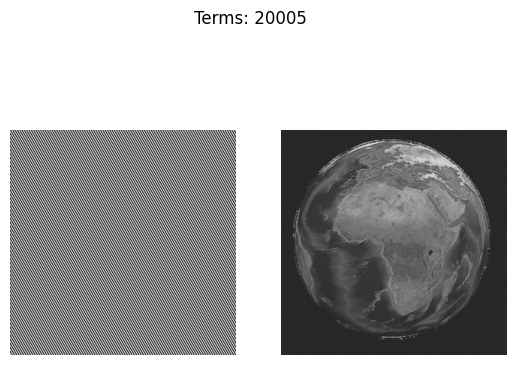

 66%|██████▋   | 30139/45451 [02:28<01:12, 212.58it/s]

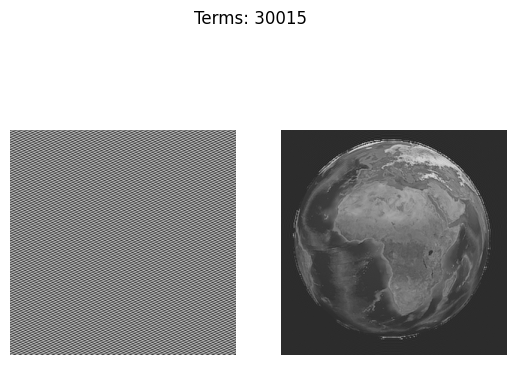

 88%|████████▊ | 40184/45451 [03:15<00:35, 148.76it/s]

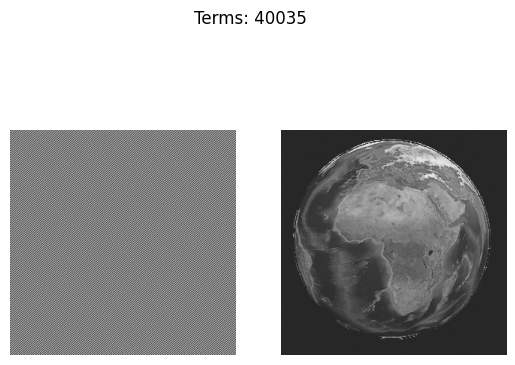

100%|██████████| 45451/45451 [03:47<00:00, 199.77it/s]


In [ ]:
# fourier_synthesis.py

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

image_filename = "Earth.png"

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

def calculate_distance_from_centre(coords, centre):
    # Distance from centre is √(x^2 + y^2)
    return np.sqrt(
        (coords[0] - centre) ** 2 + (coords[1] - centre) ** 2
    )

def find_symmetric_coordinates(coords, centre):
    return (centre + (centre - coords[0]),
            centre + (centre - coords[1]))

def display_plots(individual_grating, reconstruction, idx):
    plt.subplot(121)
    plt.imshow(individual_grating)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(reconstruction)
    plt.axis("off")
    plt.suptitle(f"Terms: {idx}")
    plt.pause(0.01)





# Read and process image
image = plt.imread(image_filename)
image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

# Array dimensions (array is square) and centre pixel
array_size = len(image)
centre = int((array_size - 1) / 2)

# Get all coordinate pairs in the left half of the array,
# including the column at the centre of the array (which
# includes the centre pixel)
coords_left_half = (
    (x, y) for x in range(array_size) for y in range(centre+1)
)

# Sort points based on distance from centre
coords_left_half = sorted(
    coords_left_half,
    key=lambda x: calculate_distance_from_centre(x, centre)
)

ft = calculate_2dft(image)





# Show grayscale image and its Fourier transform
plt.set_cmap("gray")

plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.pause(2)

# Reconstruct image
fig = plt.figure()


# Step 1
# Set up empty arrays for final image and
# individual gratings
rec_image = np.zeros(image.shape)
individual_grating = np.zeros(
    image.shape, dtype="complex"
)
idx = 0

# All steps are displayed until display_all_until value
display_all_until = 5
# After this, skip which steps to display using the
# display_step value
display_step = 10000
# Work out index of next step to display
next_display = display_all_until + display_step

# Step 2
for i in tqdm(range(len(coords_left_half))):
    coords = coords_left_half[i]
    # Central column: only include if points in top half of
    # the central column
    if not (coords[1] == centre and coords[0] > centre):
        idx += 1
        symm_coords = find_symmetric_coordinates(
            coords, centre
        )
        # Step 3
        # Copy values from Fourier transform into
        # individual_grating for the pair of points in
        # current iteration
        individual_grating[coords] = ft[coords]
        individual_grating[symm_coords] = ft[symm_coords]

        # Step 4
        # Calculate inverse Fourier transform to give the
        # reconstructed grating. Add this reconstructed
        # grating to the reconstructed image
        rec_grating = calculate_2dift(individual_grating)
        rec_image += rec_grating

        # Clear individual_grating array, ready for
        # next iteration
        individual_grating[coords] = 0
        individual_grating[symm_coords] = 0

        # Don't display every step
        if idx < display_all_until or idx == next_display:
            if idx > display_all_until:
                next_display += display_step
                # Accelerate animation the further the
                # iteration runs by increasing
                # display_step
                display_step += 10
            display_plots(rec_grating, rec_image, idx)

plt.show()

## Jak to działa:
1. Mamy transformacjie fouriera (ttf) oraz jej odwrotność (ittf).
2. Mamy funckjie gratingu $ y=\sin \left(\frac{2 \cdot \pi \cdot (X \cdot \cos(\alpha) + Y \cdot \sin(\alpha))}{\lambda} \right) $, która tworzy pasy (fale) o długości fali $ \lambda $ pod kątem $ \alpha $.
3. Gdy nałożymy wiele takich gratingów o różnych $ \lambda $ i $ \alpha $, otrzymujemy złożony obraz.
4. Fuckjia ttf dla jednego gridingu tworzy name dwa symetryczne punkty w odległości zależnej od $ \lambda $ oraz pod kątem $ \alpha $.
5. Wiele gratingów daje wiele punktów – im więcej, tym bardziej złożony obraz.
6. Dla odpowiedniu dużej ilości gridingów jeteśmy w stanie otzymać obraz. 
7. Za pomocą ttf jesteśmy w stanie odwrócicć process i wyciągnąć z niego liste liste $ \lambda $ oraz liste $ \alpha $
8. Za pomocą ittf i listy $ \lambda $ i $ \alpha $ jesteśmy w stanie przywrucić obraz. 

# Zadanie 2

In [110]:
import numpy as np

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

def calculate_distance_from_centre(coords, centre):
    # Distance from centre is √(x^2 + y^2)
    return np.sqrt(
        (coords[0] - centre) ** 2 + (coords[1] - centre) ** 2
    )

def find_symmetric_coordinates(coords, centre):
    return (centre + (centre - coords[0]),
            centre + (centre - coords[1]))






def low_pass_filtr(image, freq):
    image = image[:, :, :3].mean(axis=2)
    array_size = len(image)
    centre = int((array_size - 1) / 2)

    coords_left_half = (
        (x, y) for x in range(array_size) for y in range(centre+1)
    )

    coords_left_half = sorted(
        coords_left_half,
        key=lambda x: calculate_distance_from_centre(x, centre)
    )

    ft = calculate_2dft(image)
    centre_c = ft[centre, centre]
    
    for coords in coords_left_half:
        
        if not (coords[1] == centre and coords[0] > centre):
            
            ##### Remove points that distance less then cut point #####
            norm_dist = calculate_distance_from_centre(coords, centre)/centre
            
            if(norm_dist >= freq):
                symm_coords = find_symmetric_coordinates(
                    coords, centre
                )

                y, x = coords
                sym_y, sym_x = symm_coords

                ft[y, x] = 0
                ft[sym_y, sym_x] = 0

    ft[centre, centre] = centre_c
    mask = calculate_2dift(ft)
    # mask -= mask.min()
    # mask /= mask.max()
    # mask /= 2
    # mask += 0.5

    return mask[:, :, np.newaxis]


def high_pass_filtr(image, freq):
    image = image[:, :, :3].mean(axis=2)
    array_size = len(image)
    centre = int((array_size - 1) / 2)

    coords_left_half = (
        (x, y) for x in range(array_size) for y in range(centre+1)
    )

    coords_left_half = sorted(
        coords_left_half,
        key=lambda x: calculate_distance_from_centre(x, centre)
    )

    ft = calculate_2dft(image)
    centre_c = ft[centre, centre]
    
    for coords in coords_left_half:
        
        if not (coords[1] == centre and coords[0] > centre):
            
            ##### Remove points that distance greater then cut point #####
            norm_dist = calculate_distance_from_centre(coords, centre)/centre
            
            if(norm_dist <= freq):
                symm_coords = find_symmetric_coordinates(
                    coords, centre
                )

                y, x = coords
                sym_y, sym_x = symm_coords

                ft[y, x] = 0
                ft[sym_y, sym_x] = 0

    ft[centre, centre] = centre_c
    mask = calculate_2dift(ft)
    # mask -= mask.min()
    # mask /= mask.max()
    # mask /= 2
    # mask += 0.5

    return mask[:, :, np.newaxis]





import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider


img = plt.imread("Z2.png")
img_noise = plt.imread("Z2_noise.png")


def show_res(h, l):
    lmask = low_pass_filtr(img_noise, l)
    hmask = high_pass_filtr(img_noise, h)



    fig, ax = plt.subplots(2, 3, figsize=(30, 20))

    ax[0][0].imshow(img)
    ax[0][0].set_title("Original")
    ax[0][0].axis('off')

    ax[1][0].imshow(img_noise)
    ax[1][0].set_title("Noisy")
    ax[1][0].axis('off')

    ax[0][1].imshow(lmask)
    ax[0][1].set_title("LMask")
    ax[0][1].axis('off')

    ax[1][1].imshow(hmask)
    ax[1][1].set_title("HMask")
    ax[1][1].axis('off')

    ax[0][2].imshow(img_noise * lmask)
    ax[0][2].set_title("L Filtered")
    ax[0][2].axis('off')

    ax[1][2].imshow(img_noise * hmask)
    ax[1][2].set_title("H Filtered")
    ax[1][2].axis('off')

    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[0].axis('off')

    ax[1].imshow(img_noise)
    ax[1].set_title("Noise")
    ax[1].axis('off')

    ax[2].imshow(img_noise * hmask * lmask)
    ax[2].set_title("Filtered")
    ax[2].axis('off')

    plt.show()



interact(show_res,
    l=FloatSlider(min=0, max=1, step=0.01, value=0.3),
    h=FloatSlider(min=0, max=1, step=0.01, value=0.06))

interactive(children=(FloatSlider(value=0.06, description='h', max=1.0, step=0.01), FloatSlider(value=0.3, des…

<function __main__.show_res(h, l)>